# Mongo And Vs Or Query Times

In [1]:
%matplotlib inline

from pymongo import MongoClient
import random
import time

URL = None
DATABASE = "yummly"
RECIPES_COLLECTION = "recipesWAt"
SAMPLE_SIZE = 100
RAND_SEED = 10
RMIN = 1
RMAX = 10

client = MongoClient(URL) if URL else MongoClient()
db = client[DATABASE]
recipes_coll = db[RECIPES_COLLECTION]

random.seed(RAND_SEED)
samples = {}
for r in range(RMIN, RMAX + 1):
    
    # get count of recipes containing r or more ingredients
    sample_filter = {
        "$where": "this.ingredients.length >= {r} && this.ingredients.length <= {RMAX}".format(r=r, RMAX=RMAX)
    }
    count = recipes_coll.count(sample_filter)
    
    # get sorted list of SAMPLE_SIZE random indexes of value < r
    to_sample = random.sample(range(0,count), SAMPLE_SIZE)
    to_sample.sort()
    
    # get the recipes at the random indexes
    cursor = recipes_coll.find(sample_filter)
    position = 0
    samples[r] = []
    for index in to_sample:
        while position <= index:
            record = cursor.next()
            position += 1
        
        # and extract a random combination from the recipe's ingredients
        ingredients = list(record['ingredients'])
        random.shuffle(ingredients)
        samples[r].append(ingredients[:r])

print(samples)

{1: [['green beans'], ['rolled oats'], ['sugar'], ['simple syrup'], ['split peas'], ['parmesan cheese'], ['eggs'], ['olive oil'], ['oil'], ['sour cream'], ['italian sausage'], ['minced garlic'], ['bread crumbs'], ['garlic cloves'], ['whole wheat flour'], ['chinese broccoli'], ['apple juice concentrate'], ['chips'], ['eggs'], ['garlic cloves'], ['garlic salt'], ['saffron threads'], ['sweet potatoes'], ['milk'], ['crackers'], ['low sodium chicken broth'], ['pork tenderloin'], ['bay leaf'], ['turkey broth'], ['summer squash'], ['coarse salt'], ['cranberries'], ['sugar'], ['chopped pecans'], ['extra-virgin olive oil'], ['garlic'], ['1% low-fat milk'], ['asparagus'], ['teriyaki sauce'], ['light mayonnaise'], ['butter'], ['double-acting baking powder'], ['pepper jack chees'], ['salt'], ['fresh ginger'], ['vegetable oil'], ['bananas'], ['vegetable oil'], ['parmesan cheese'], ['golden raisins'], ['sesame seeds'], ['white vinegar'], ['dry mustard'], ['parsley sprigs'], ['boneless chicken breast

## Query And-Counts

In [2]:
and_times = {}

for r in sorted(samples, reverse=True):
    combos = samples[r]
    and_times[r] = []
    for ingredients in combos:
        start = time.time()

        and_count = db[RECIPES_COLLECTION].find({
            "ingredients": {
                "$all": ingredients
            }
        }).count()

        end = time.time()
        and_times[r].append(end - start)

print(and_times)

{1: [0.001180410385131836, 0.0006716251373291016, 0.008667469024658203, 0.0004954338073730469, 0.0004532337188720703, 0.0016927719116210938, 0.0068836212158203125, 0.018631696701049805, 0.002408742904663086, 0.0035016536712646484, 0.0006442070007324219, 0.0032329559326171875, 0.0009822845458984375, 0.01007843017578125, 0.0011823177337646484, 0.0004513263702392578, 0.00043773651123046875, 0.0006005764007568359, 0.007580280303955078, 0.01021265983581543, 0.001215219497680664, 0.0006256103515625, 0.0013933181762695312, 0.00531315803527832, 0.0006761550903320312, 0.0009446144104003906, 0.0007240772247314453, 0.001383066177368164, 0.0006148815155029297, 0.00047707557678222656, 0.0015048980712890625, 0.0007579326629638672, 0.008152246475219727, 0.0010600090026855469, 0.004904031753540039, 0.006081342697143555, 0.0006108283996582031, 0.001046895980834961, 0.0004131793975830078, 0.0005702972412109375, 0.0076868534088134766, 0.00042176246643066406, 0.00047969818115234375, 0.03987693786621094, 0

## Query Or-Counts

In [3]:
or_times = {}

for r in sorted(samples, reverse=True):
    combos = samples[r]
    or_times[r] = []
    for ingredients in combos:
        start = time.time()

        and_count = db[RECIPES_COLLECTION].find({
            "ingredients": {
                "$in": ingredients
            }
        }).count()

        end = time.time()
        or_times[r].append(end - start)

print(or_times)

{1: [0.0013997554779052734, 0.000701904296875, 0.014467000961303711, 0.0005810260772705078, 0.0004966259002685547, 0.0020215511322021484, 0.013390541076660156, 0.02485966682434082, 0.0029070377349853516, 0.004300117492675781, 0.0006787776947021484, 0.003684520721435547, 0.0011162757873535156, 0.014053821563720703, 0.0012934207916259766, 0.0004353523254394531, 0.0003685951232910156, 0.0005638599395751953, 0.012958526611328125, 0.015240192413330078, 0.0013518333435058594, 0.0006487369537353516, 0.001497030258178711, 0.009690284729003906, 0.0008947849273681641, 0.0008273124694824219, 0.0008296966552734375, 0.0014581680297851562, 0.000438690185546875, 0.0004048347473144531, 0.0017781257629394531, 0.0008182525634765625, 0.01414036750793457, 0.0013713836669921875, 0.009935617446899414, 0.009023904800415039, 0.0009894371032714844, 0.002495288848876953, 0.0008900165557861328, 0.0011205673217773438, 0.011646747589111328, 0.0008025169372558594, 0.001043081283569336, 0.05852222442626953, 0.002068

## Compare Query Times

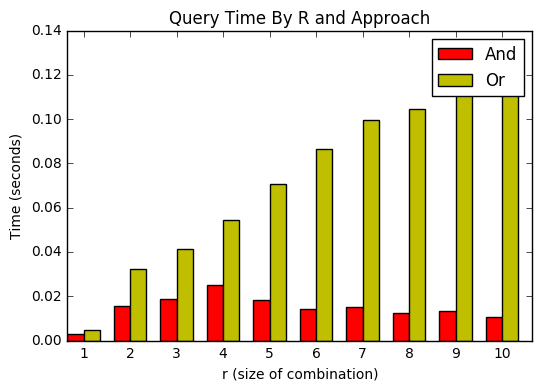

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# http://matplotlib.org/examples/api/barchart_demo.html

N = len(and_times.keys())
preMeans = [sum(and_times[r]) / float(len(and_times[r])) for r in sorted(and_times.keys())]
#calculate standard deviation
preStd = None

ind = np.arange(N)
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(ind, preMeans, width, color='r')

otfMeans = [sum(or_times[r]) / float(len(or_times[r])) for r in sorted(or_times.keys())]
otfStd = None
rects2 = ax.bar(ind + width, otfMeans, width, color='y')

ax.set_ylabel('Time (seconds)')
ax.set_xlabel('r (size of combination)')
ax.set_title('Query Time By R and Approach')
ax.set_xticks(ind + width)
ax.set_xticklabels(('1', '2', '3', '4', '5', '6', '7', '8', '9', '10'))

ax.legend((rects1[0], rects2[0]), ('And', 'Or'))

plt.show()